<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### **Alumno:** Simón Rodríguez

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [50]:
import random
import io
import pickle
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset el libro de Viaje al Centro de la Tierra de Julio Verne.

In [51]:
# Descargar la carpeta de dataset
import os
import platform

directory = './dataset/text_corpus'

if os.access(directory, os.F_OK) is False:
    os.makedirs(directory)
if os.access('desafio_2.zip', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/simon-rodriguez/CEIA_procesamiento_lenguaje_natural/main/datasets/text_corpus/desafio_2.zip -O {directory}/desafio_2.zip

    else:
        !wget -O {directory}/desafio_2.zip https://github.com/simon-rodriguez/CEIA_procesamiento_lenguaje_natural/raw/main/datasets/text_corpus/desafio_2.zip

    !unzip -q {directory}/desafio_2.zip -d {directory}

else:
    print("El dataset ya se encuentra descargado")

--2024-09-28 20:00:31--  https://github.com/simon-rodriguez/CEIA_procesamiento_lenguaje_natural/raw/main/datasets/text_corpus/desafio_2.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/simon-rodriguez/CEIA_procesamiento_lenguaje_natural/main/datasets/text_corpus/desafio_2.zip [following]
--2024-09-28 20:00:32--  https://raw.githubusercontent.com/simon-rodriguez/CEIA_procesamiento_lenguaje_natural/main/datasets/text_corpus/desafio_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 778409 (760K) [application/zip]
Saving to: ‘./dataset/text_corpus/desafio_2.zip’

./dataset/text_corp 100%[

In [52]:
# Posibles libros
os.listdir("./dataset/text_corpus")

['the_adventures_of_sherlock_holmes_sentences.txt',
 'viaje_al_centro_de_la_tierra_sentences.txt',
 'el_arte_de_la_guerra.txt',
 'the_adventures_of_sherlock_holmes.txt',
 'desafio_2.zip',
 'viaje_al_centro_de_la_tierra.txt']

In [53]:
# Se abre el archivo de texto y se guarda como un gran string (todo junto)
with open('./dataset/text_corpus/viaje_al_centro_de_la_tierra.txt', 'r') as f:
    article_text = f.read()

# Se convierte todo el texto a minúsculas
#article_text = article_text.lower()

In [54]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

'Viaje al Centro de la Tierra\nJulio Verne\nCapítulo 1\nEl domingo 24 de mayo de 1863, mi tío, el profesor Lidenbrock, entró rápidamente a su hogar, situado en el número 19 de la König‑Strasse, una de las calles más tradicionales del barrio antiguo de Hamburgo.\nMarta, su excelente criada, se preocupó sobremanera, creyendo que se había retrasado, pues apenas empezaba a cocinar la comida en el hornillo.\n“Bueno” —pensé para mí—, “si mi tío viene con hambre, se va a armar la de San Quintín; porque no conozco a otro hombre de menos paciencia”.\n—¡Tan temprano y ya está aquí el señor Lidenbrock! —exclamó la pobre Marta, con arrebol, entreabriendo la puerta del comedor.\n—Sí, Marta; pero tú no tienes la culpa de que la comida no esté lista todavía, porque es temprano, aún no son las dos. Acaba de dar la media hora en San Miguel.\n—¿Y por qué ha venido tan pronto el señor Lidenbrock?\n—Él lo explicará, seguramente.\n—¡Ahí viene! Yo me escapo. Señor Axel, cálmelo usted, por favor.\nY la excel

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [55]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [56]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [57]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [58]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

104

In [59]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [60]:
char2idx

{'1': 0,
 'j': 1,
 '?': 2,
 'w': 3,
 '¿': 4,
 'O': 5,
 '—': 6,
 'V': 7,
 'S': 8,
 '3': 9,
 'W': 10,
 "'": 11,
 '4': 12,
 'J': 13,
 '/': 14,
 'P': 15,
 'B': 16,
 'X': 17,
 '‑': 18,
 'â': 19,
 'a': 20,
 '«': 21,
 ';': 22,
 'E': 23,
 'á': 24,
 'y': 25,
 'x': 26,
 'Q': 27,
 '+': 28,
 'K': 29,
 'k': 30,
 'd': 31,
 'L': 32,
 '9': 33,
 'r': 34,
 'l': 35,
 'i': 36,
 'n': 37,
 '”': 38,
 'ä': 39,
 'u': 40,
 '\n': 41,
 'b': 42,
 'z': 43,
 'Z': 44,
 '6': 45,
 'U': 46,
 'é': 47,
 'h': 48,
 '!': 49,
 'É': 50,
 '.': 51,
 't': 52,
 'p': 53,
 ':': 54,
 'Á': 55,
 'm': 56,
 '7': 57,
 'q': 58,
 '-': 59,
 '“': 60,
 '°': 61,
 'T': 62,
 'c': 63,
 'D': 64,
 ',': 65,
 'G': 66,
 'o': 67,
 'N': 68,
 '―': 69,
 'H': 70,
 '(': 71,
 'f': 72,
 'ö': 73,
 'F': 74,
 'ü': 75,
 'ú': 76,
 'M': 77,
 '0': 78,
 'ñ': 79,
 '5': 80,
 's': 81,
 '…': 82,
 '\xad': 83,
 'Í': 84,
 'I': 85,
 'R': 86,
 'ﬂ': 87,
 'œ': 88,
 'e': 89,
 '2': 90,
 '–': 91,
 ' ': 92,
 '»': 93,
 'C': 94,
 'í': 95,
 'ó': 96,
 'g': 97,
 'A': 98,
 'v': 99,
 'Y': 

###  Tokenizar

In [61]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [62]:
tokenized_text[:1000]

[7,
 36,
 20,
 1,
 89,
 92,
 20,
 35,
 92,
 94,
 89,
 37,
 52,
 34,
 67,
 92,
 31,
 89,
 92,
 35,
 20,
 92,
 62,
 36,
 89,
 34,
 34,
 20,
 41,
 13,
 40,
 35,
 36,
 67,
 92,
 7,
 89,
 34,
 37,
 89,
 41,
 94,
 20,
 53,
 95,
 52,
 40,
 35,
 67,
 92,
 0,
 41,
 23,
 35,
 92,
 31,
 67,
 56,
 36,
 37,
 97,
 67,
 92,
 90,
 12,
 92,
 31,
 89,
 92,
 56,
 20,
 25,
 67,
 92,
 31,
 89,
 92,
 0,
 103,
 45,
 9,
 65,
 92,
 56,
 36,
 92,
 52,
 95,
 67,
 65,
 92,
 89,
 35,
 92,
 53,
 34,
 67,
 72,
 89,
 81,
 67,
 34,
 92,
 32,
 36,
 31,
 89,
 37,
 42,
 34,
 67,
 63,
 30,
 65,
 92,
 89,
 37,
 52,
 34,
 96,
 92,
 34,
 24,
 53,
 36,
 31,
 20,
 56,
 89,
 37,
 52,
 89,
 92,
 20,
 92,
 81,
 40,
 92,
 48,
 67,
 97,
 20,
 34,
 65,
 92,
 81,
 36,
 52,
 40,
 20,
 31,
 67,
 92,
 89,
 37,
 92,
 89,
 35,
 92,
 37,
 76,
 56,
 89,
 34,
 67,
 92,
 0,
 33,
 92,
 31,
 89,
 92,
 35,
 20,
 92,
 29,
 73,
 37,
 36,
 97,
 18,
 8,
 52,
 34,
 20,
 81,
 81,
 89,
 65,
 92,
 40,
 37,
 20,
 92,
 31,
 89,
 92,
 35,
 20,
 81,
 92,
 6

### Organizando y estructurando el dataset

In [63]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [64]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [65]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [66]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [67]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [68]:
X.shape

(382265, 100)

In [69]:
X[0,:10]

array([ 7, 36, 20,  1, 89, 92, 20, 35, 92, 94])

In [70]:
y[0,:10]

array([36, 20,  1, 89, 92, 20, 35, 92, 94, 89])

In [71]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [72]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [73]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_1 (TimeDistributed) │ (None, None, 104)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 200)           │          61,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 104)           │          20,904 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,904 (319.94 KB)

 Trainable params: 81,904 (319.94 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [74]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model_min.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [75]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl, patience=7)], batch_size=256)

Epoch 1/20
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.5071


 mean perplexity: 6.606943561550845 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 77s 47ms/step - loss: 2.5069
Epoch 2/20
1492/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9795


 mean perplexity: 5.646371620013822 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - loss: 1.9795
Epoch 3/20
1491/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8669


 mean perplexity: 5.230126909557962 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - loss: 1.8669
Epoch 4/20
1492/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8145


 mean perplexity: 5.086278235678618 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - loss: 1.8144
Epoch 5/20
1492/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7848


 mean perplexity: 4.939380759647242 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - loss: 1.7848
Epoch 6/20
1492/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7655


 mean perplexity: 4.913485055217378 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - loss: 1.7654
Epoch 7/20
1493/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7508


 mean perplexity: 4.837378450075655 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 1.7508
Epoch 8/20
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7393


 mean perplexity: 4.795620324526378 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - loss: 1.7393
Epoch 9/20
1493/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7316


 mean perplexity: 4.790423509361583 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - loss: 1.7316
Epoch 10/20
1491/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7236


 mean perplexity: 4.745235433103477 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - loss: 1.7236
Epoch 11/20
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7168


 mean perplexity: 4.653154673008477 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - loss: 1.7168
Epoch 12/20
1493/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7109
 mean perplexity: 4.704716701684103 

1494/1494 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - loss: 1.7109
Epoch 13/20
1493/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7069


 mean perplexity: 4.631449097768355 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - loss: 1.7069
Epoch 14/20
1493/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7031


 mean perplexity: 4.606794704060383 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - loss: 1.7031
Epoch 15/20
1493/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6995


 mean perplexity: 4.595866914106854 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - loss: 1.6995
Epoch 16/20
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6954


 mean perplexity: 4.589147802191247 

Saved new model!
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - loss: 1.6954
Epoch 17/20
1493/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6941
 mean perplexity: 4.609288538870035 

1494/1494 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - loss: 1.6941
Epoch 18/20
1493/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6903
 mean perplexity: 4.598231928168893 

1494/1494 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - loss: 1.6903
Epoch 19/20
1491/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6890
 mean perplexity: 4.618815218882989 

1494/1494 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - loss: 1.6890
Epoch 20/20
1494/1494 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6866
 mean perplexity: 4.602568612064114 

1494/1494 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - loss: 1.6866


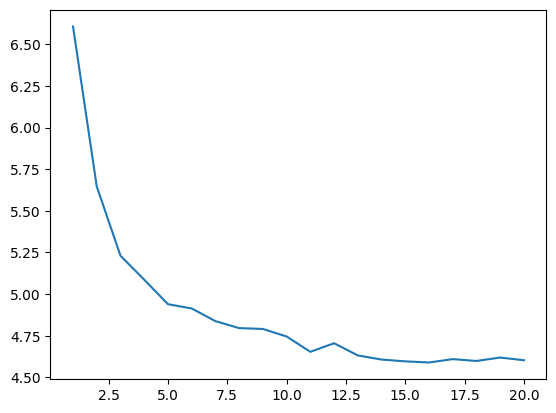

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [77]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model_min.h5')


### Predicción del próximo caracter

In [78]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [79]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c68ddfcf379375163e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c68ddfcf379375163e.gradio.live


### Generación de secuencias

In [80]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [93]:
input_text='mi tio era '

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'mi tio era entre las cual se encontrar a '

###  Beam search y muestreo aleatorio

In [82]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [83]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [105]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=50,mode='sto', input="mi tio era")

In [106]:
salidas[0]

array([56, 36, 92, 52, 36, 67, 92, 89, 34, 20, 92, 53, 34, 89, 63, 36, 81,
       67, 92, 89, 37, 92, 89, 35, 92, 56, 20, 34, 92, 31, 89, 92, 35, 20,
       81, 92, 63, 40, 20, 35, 89, 81, 92, 31, 89, 92, 35, 20, 81, 92, 89,
       37, 52, 34, 89, 92, 31, 89, 35, 92])

In [107]:
# veamos las salidas
print(f"Opcion 1: {decode(salidas[0])}")
print(f"Opcion 2: {decode(salidas[1])}")
print(f"Opcion 3: {decode(salidas[2])}")
print(f"Opcion 4: {decode(salidas[3])}")
print(f"Opcion 5: {decode(salidas[4])}")

Opcion 1: mi tio era preciso en el mar de las cuales de las entre del 
Opcion 2: mi tio era preciso en el mar de las cuales de las entre detá
Opcion 3: mi tio era preciso en el mar de las cuales de las entre del 
Opcion 4: mi tio era preciso en el mar de las cuales de las entre del 
Opcion 5: mi tio era preciso en el mar de las cuales de las entre desp


In [108]:
# predicción con beam search
salidas_det = beam_search(model,num_beams=10,num_words=50,mode='det', input="mi tio era")

In [110]:
# veamos las salidas
print(f"Opcion 1: {decode(salidas_det[0])}")
print(f"Opcion 2: {decode(salidas_det[1])}")
print(f"Opcion 3: {decode(salidas_det[2])}")
print(f"Opcion 4: {decode(salidas_det[3])}")
print(f"Opcion 5: {decode(salidas_det[4])}")

Opcion 1: mi tio era profesor Lidenbrock, el profesor Lidenbrock, que 
Opcion 2: mi tio era profesor Lidenbrock, por el profesor Lidenbrock, 
Opcion 3: mi tio era profesor Lidenbrock, el profesor Lidenbrock de la
Opcion 4: mi tio era profesor Lidenbrock, el profesor Lidenbrock, por 
Opcion 5: mi tio era profesor Lidenbrock, por el profesor Lidenbrock.



In [112]:
input_text='mi tio era '
n_words = 50

# predicción con greedy search
salida_greedy = generate_seq(model, input_text, max_length=max_context_size, n_words=n_words)
# predicción con beam search, modo estoico
salidas_sto = beam_search(model,num_beams=10,num_words=n_words,mode='sto', input=input_text)
# predicción con beam search, modo determinista
salidas_det = beam_search(model,num_beams=10,num_words=n_words,mode='det', input=input_text)


# veamos las salidas
print("--------------------------------------")
print(f"Greedy Search: {salida_greedy}")
print("--------------------------------------")
print(f"Beam Search (sto): {decode(salidas_sto[0])}")
print("--------------------------------------")
print(f"Beam Search (det): {decode(salidas_det[0])}")
print("--------------------------------------")
print("--------------------------------------")

--------------------------------------
Greedy Search: mi tio era entre las cual se encontrar a la parecía a la mano
--------------------------------------
Beam Search (sto): mi tio era el profesor Lidenbrock de las palabras de las roca
--------------------------------------
Beam Search (det): mi tio era profesor Lidenbrock, el profesor Lidenbrock, que e
--------------------------------------
--------------------------------------


In [115]:
input_text='Lidenbrock es '
n_words = 50

# predicción con greedy search
salida_greedy = generate_seq(model, input_text, max_length=max_context_size, n_words=n_words)
# predicción con beam search, modo estoico
salidas_sto = beam_search(model,num_beams=10,num_words=n_words,mode='sto', input=input_text)
# predicción con beam search, modo determinista
salidas_det = beam_search(model,num_beams=10,num_words=n_words,mode='det', input=input_text)


# veamos las salidas
print("--------------------------------------")
print(f"Greedy Search: {salida_greedy}")
print("--------------------------------------")
print(f"Beam Search (sto): {decode(salidas_sto[0])}")
print("--------------------------------------")
print(f"Beam Search (det): {decode(salidas_det[0])}")
print("--------------------------------------")
print("--------------------------------------")

--------------------------------------
Greedy Search: Lidenbrock es el camino de la cabeza de la cabeza de la cabeza d
--------------------------------------
Beam Search (sto): Lidenbrock es profesor Lidenbrock, en las rocas de los inclinari
--------------------------------------
Beam Search (det): Lidenbrock es que el profesor Lidenbrock, el profesor Lidenbrock
--------------------------------------
--------------------------------------


In [116]:
input_text='¿Quien es? Ella es  '
n_words = 50

# predicción con greedy search
salida_greedy = generate_seq(model, input_text, max_length=max_context_size, n_words=n_words)
# predicción con beam search, modo estoico
salidas_sto = beam_search(model,num_beams=10,num_words=n_words,mode='sto', input=input_text)
# predicción con beam search, modo determinista
salidas_det = beam_search(model,num_beams=10,num_words=n_words,mode='det', input=input_text)


# veamos las salidas
print("--------------------------------------")
print(f"Greedy Search: {salida_greedy}")
print("--------------------------------------")
print(f"Beam Search (sto): {decode(salidas_sto[0])}")
print("--------------------------------------")
print(f"Beam Search (det): {decode(salidas_det[0])}")
print("--------------------------------------")
print("--------------------------------------")

--------------------------------------
Greedy Search: ¿Quien es? Ella es  otra vez en el camino de la cabeza de la cabeza de
--------------------------------------
Beam Search (sto): ¿Quien es? Ella es  leguas de este mar en las cuales de las espacios a
--------------------------------------
Beam Search (det): ¿Quien es? Ella es  respondió el profesor Lidenbrock, el profesor Lide
--------------------------------------
--------------------------------------


In [117]:
input_text='Mi tío '
n_words = 50

# predicción con greedy search
salida_greedy = generate_seq(model, input_text, max_length=max_context_size, n_words=n_words)
# predicción con beam search, modo estoico
salidas_sto = beam_search(model,num_beams=10,num_words=n_words,mode='sto', input=input_text)
# predicción con beam search, modo determinista
salidas_det = beam_search(model,num_beams=10,num_words=n_words,mode='det', input=input_text)


# veamos las salidas
print("--------------------------------------")
print(f"Greedy Search: {salida_greedy}")
print("--------------------------------------")
print(f"Beam Search (sto): {decode(salidas_sto[0])}")
print("--------------------------------------")
print(f"Beam Search (det): {decode(salidas_det[0])}")
print("--------------------------------------")
print("--------------------------------------")

--------------------------------------
Greedy Search: Mi tío se encontrar a la parecía a la mano de la cabeza d
--------------------------------------
Beam Search (sto): Mi tío con la superficie de las construidas en el contrar
--------------------------------------
Beam Search (det): Mi tío mi tío, que el profesor Lidenbrock, el profesor Li
--------------------------------------
--------------------------------------
